# Elektromobilität in den USA - Entwicklungen und Unterschiede

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from folium.plugins import HeatMap

## Data Preperation

### Datensatz 1

Link zum Datensatz 1: https://afdc.energy.gov/vehicle-registration

In [138]:
# dataset 1 - vehicle registrations
registrations = pd.read_csv('data/vehicle_registrations.csv')

registrations.rename(columns={'Electric (EV)': 'Electric'}, inplace=True)

for column_name, values in registrations.items():
    if column_name != 'State':
        registrations[column_name] = registrations[column_name].replace({',': ''}, regex=True).astype(int)

columns_to_remove = ['Plug-In Hybrid Electric (PHEV)', 'Hybrid Electric (HEV)']
registrations['Hybrid'] = registrations[columns_to_remove].sum(axis=1)
registrations.drop(columns=columns_to_remove, inplace=True)

columns_to_remove = ['Gasoline', 'Diesel']
registrations['Fuel'] = registrations[columns_to_remove].sum(axis=1)
registrations.drop(columns=columns_to_remove, inplace=True)

columns_to_remove = ['Biodiesel', 'Ethanol/Flex (E85)', 'Compressed Natural Gas (CNG)', 'Propane', 'Hydrogen', 'Methanol', 'Unknown Fuel']
registrations['Other'] = registrations[columns_to_remove].sum(axis=1)
registrations.drop(columns=columns_to_remove, inplace=True)

In [139]:
registrations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Year      357 non-null    int64 
 1   State     357 non-null    object
 2   Electric  357 non-null    int64 
 3   Hybrid    357 non-null    int64 
 4   Fuel      357 non-null    int64 
 5   Other     357 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 16.9+ KB


In [140]:
registrations.head()

,Year,State,Electric,Hybrid,Fuel,Other
0,2016,Alabama,500,30000,3903800,502300
1,2016,Alaska,200,5200,570700,80000
2,2016,Arizona,4700,94000,4984500,557700
3,2016,Arkansas,200,19600,2194600,355300
4,2016,California,141500,1083400,27951400,1520400


### Datensatz 2

Link zum Datensatz 2: https://afdc.energy.gov/data_download/
+ Dataset "Alternative fuel stations"
+ Fuel type "Electric"

In [141]:
# dataset 2 - alternative fuel stations
columns_to_keep = ['State', 'Latitude', 'Longitude', 'Open Date']

stations = pd.read_csv('data/alt_fuel_stations (Dec 2 2023).csv', usecols=columns_to_keep, engine='python')

stations['Open Date'] = pd.to_datetime(stations['Open Date'], format='%Y-%m-%d')

In [142]:
stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68016 entries, 0 to 68015
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   State      68002 non-null  object        
 1   Latitude   68016 non-null  float64       
 2   Longitude  68016 non-null  float64       
 3   Open Date  67868 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 2.1+ MB


In [143]:
stations.head()

,State,Latitude,Longitude,Open Date
0,CA,34.248319,-118.387971,1999-10-15
1,CA,34.052542,-118.448504,2020-02-28
2,CA,34.040539,-118.271387,1995-08-30
3,CA,34.059133,-118.248589,1999-10-15
4,CA,33.759802,-118.096665,2018-05-01


### Datensatz 3

Eigens zusammengestellter Datensatz anhand der folgenden Quellen:
+ https://en.wikipedia.org/wiki/Red_states_and_blue_states#/media/File:Red_state,_blue_state.svg
+ https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_population
+ https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_area

In [144]:
# dataset 3 - USA
usa = pd.read_csv('data/usa.csv')

columns_to_int = ['Population', 'Land_area']
usa[columns_to_int] = usa[columns_to_int].replace({',': ''}, regex=True).apply(pd.to_numeric)

In [145]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   State         51 non-null     object
 1   Abbreviation  51 non-null     object
 2   Vote          51 non-null     object
 3   Population    51 non-null     int64 
 4   Land_area     51 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.1+ KB


In [146]:
usa.head()

,State,Abbreviation,Vote,Population,Land_area
0,Alabama,AL,red,5074296,131171
1,Alaska,AK,red,733583,1477953
2,Arizona,AZ,lightred,7359197,294207
3,Arkansas,AR,red,3045637,134771
4,California,CA,blue,39029342,403466


## Modelling

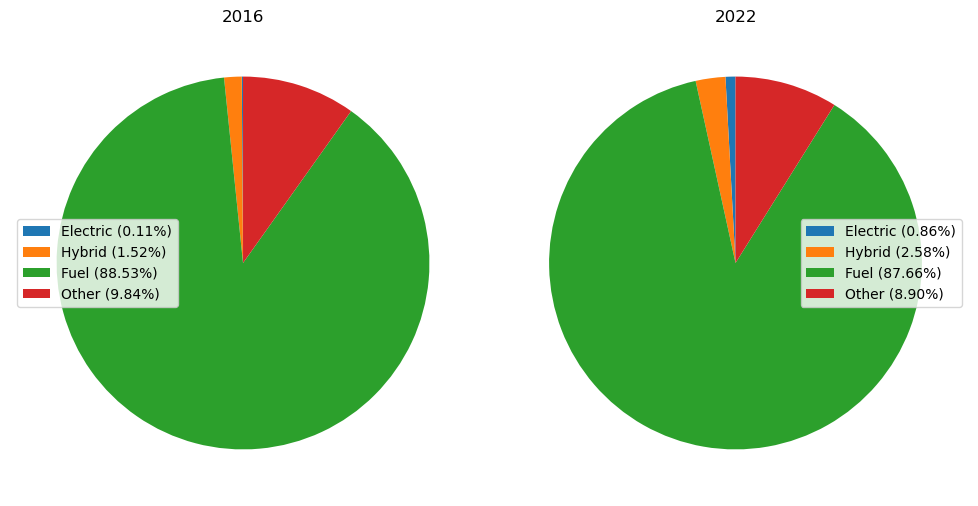

In [147]:
# Vergleich Anteil 2016 zu 2022
registrations_type16 = registrations[registrations['Year'] == 2016]
registrations_type16 = registrations_type16.drop(columns={'Year', 'State'})
registrations_type16 = registrations_type16.sum()

registrations_type22 = registrations[registrations['Year'] == 2022]
registrations_type22 = registrations_type22.drop(columns={'Year', 'State'})
registrations_type22 = registrations_type22.sum()

legend16 = [f'{label} ({value/registrations_type16.sum()*100:.2f}%)' for label, value in zip(registrations_type16.index, registrations_type16)]
legend22 = [f'{label} ({value/registrations_type22.sum()*100:.2f}%)' for label, value in zip(registrations_type22.index, registrations_type22)]

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].pie(registrations_type16, startangle=90)
axs[0].set_title('2016')
axs[0].set_xticks(axs[0].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90, fontsize=8)
axs[0].legend(legend16, loc="center left")

axs[1].pie(registrations_type22, startangle=90)
axs[1].set_title('2022')
axs[1].set_xticks(axs[1].get_xticks())
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, fontsize=8)
axs[1].legend(legend22, loc="center right")

plt.tight_layout()
plt.show()